# Week 18 Homework
### Introduction to Neural Networks

## 1. What is a neural network? What are the general steps required to build a neural network?

A neural network is a complex predictive model. The models we have worked with up to this point have considered how input features interact with the output feature. Neural network add layers of understanding that learn the interactions between input features, themselves, and how those combinations of interactions interact with the target variable to make better real-world predictions. Generally, to build a neural network, you separate your input features from your output. Then you select and instantiate the model. You next add hidden layers (or several) of nodes, model constructors and layer constructors. Then you compile your model with the help of an optimizer and a loss function. Next, you create activation functions to apply backpropagation and gradient descent. This will bounce the predictions forward and backward from input layer thru hidden layers to output layer over several iterations, or epochs, where the neural network is adding to it's abilities to capture interactions between features and adjusting their associated weights with each pass. Hopefully this culminates in the lowest possible error, but sometimes a stop condition is used to cap the processing, instead.

## 2. Generally, how do you check the performance of a neural network? Why? 

## 3. Create a neural network using keras to predict the outcome of either of these datasets: 
Cardiac Arrhythmia: https://archive.ics.uci.edu/ml/datasets/Arrhythmia 

Abalone age: https://archive.ics.uci.edu/ml/datasets/Abalone

In [77]:
# Dependencies and modules:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm

from pprint import pp
from IPython.display import Audio
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from keras import backend
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, History
from keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD

# Audible cell-completion notification:
Audio('Bicycle-bell.mp3', autoplay=True)

In [86]:
# Hotfix for an outdated cell enumerator with my version of notebook:

import nbformat as nbf
from glob import glob

import uuid
def get_cell_id(id_length=8):
    return uuid.uuid4().hex[:id_length]

#notebook name/keyword
nb_name = 'Week 18 Homework'
notebooks = list(filter(lambda x: nb_name in x, glob("./*.ipynb", recursive=True)))

# iterate over notebooks
for ipath in sorted(notebooks):
    # load notebook
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)
    
    cell_ids = []
    for cell in ntbk.cells:
        cell_ids.append(cell['id'])

    # reset cell ids if there are duplicates
    if not len(cell_ids) == len(set(cell_ids)): 
        for cell in ntbk.cells:
            cell['id'] = get_cell_id()

    nbf.write(ntbk, ipath)

### Abalone dataset from last class: 
#### Because neural networks can work well on raw data per DataCamp, I'm going to run two datasets thru my modeling. abalone_df will be mostly raw data (except for factorizing the sex column and adding an age column) and the abalone dataframe will have multicollinear features dropped and outliers removed.

In [87]:
# reading in the abalone.data file:
abalone_df = pd.read_csv('abalone.data',header=None, names=['Sex',
                                                            'Length',
                                                            'Diameter',
                                                            'Height',
                                                            'Whole weight',
                                                            'Shucked weight',
                                                            'Viscera weight',
                                                            'Shell weight',
                                                            'Rings',])

# Feature engineering and selection:
abalone_df['Age in years'] = abalone_df['Rings']+1.5


# Factorizing Sex column:
column = ['Sex']
for i in column:
    abalone_df["Coded "+i] = pd.factorize(abalone_df[i])[0]+1
    code_key = pd.DataFrame(abalone_df[i])
    code_key["Code for "+i]=abalone_df["Coded "+i]
    abalone_df = abalone_df.drop(i,axis=1)
    print(code_key[[i,"Code for "+i]].value_counts())

Sex  Code for Sex
M    1               1528
I    3               1342
F    2               1307
dtype: int64


### Cleaned data:

In [88]:
abalone_df.head(3)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age in years,Coded Sex
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15,16.5,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7,8.5,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9,10.5,2


In [89]:
#Splitting into input and output features:
X_df = abalone_df.drop('Age in years',axis=1).values
y_df = abalone_df['Age in years'].values

# Split into training and test sets:
X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(X_df, y_df, test_size = 0.33, random_state=42) 
# Examine shape of scrubbed training dataset:
print(X_df.shape, y_df.shape)

(4177, 9) (4177,)


### Pre-processed Data:

In [90]:
abalone = abalone_df.drop(labels=['Rings','Whole weight', 'Viscera weight', 'Shucked weight'], axis=1)
abalone.head(3)

,Length,Diameter,Height,Shell weight,Age in years,Coded Sex
0,0.455,0.365,0.095,0.15,16.5,1
1,0.350,0.265,0.090,0.07,8.5,1
2,0.530,0.420,0.135,0.21,10.5,2


In [91]:
#Splitting into input and output features:
X = abalone.drop('Age in years',axis=1).values
y = abalone['Age in years'].values

# Split into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)    

# Removing outliers with Isolation Forest:
iso = IsolationForest(contamination=0.1)
# identify outliers with module:
y_pred =iso.fit_predict(X)
# slice for rows that don't have outliers:
mask = y_pred != -1
X, y = X[mask, :], y[mask]
# Examine shape of scrubbed training dataset:
print(X.shape, y.shape)

(3759, 5) (3759,)


### Creating the keras neural network:

### Cleaned data:

In [92]:
# Finding number of input features:
n_cols_df = X_df.shape[1]
n_cols_df

9

Epoch 1/500
1/1 - 0s - loss: 153.6752 - rmse: 11.9147 - 290ms/epoch - 290ms/step
Epoch 2/500
1/1 - 0s - loss: 143.4448 - rmse: 11.5115 - 8ms/epoch - 8ms/step
Epoch 3/500
1/1 - 0s - loss: 133.4962 - rmse: 11.1062 - 10ms/epoch - 10ms/step
Epoch 4/500
1/1 - 0s - loss: 123.7883 - rmse: 10.6962 - 10ms/epoch - 10ms/step
Epoch 5/500
1/1 - 0s - loss: 114.3218 - rmse: 10.2809 - 9ms/epoch - 9ms/step
Epoch 6/500
1/1 - 0s - loss: 105.1943 - rmse: 9.8647 - 18ms/epoch - 18ms/step
Epoch 7/500
1/1 - 0s - loss: 96.5967 - rmse: 9.4551 - 8ms/epoch - 8ms/step
Epoch 8/500
1/1 - 0s - loss: 88.4739 - rmse: 9.0518 - 9ms/epoch - 9ms/step
Epoch 9/500
1/1 - 0s - loss: 80.7107 - rmse: 8.6486 - 11ms/epoch - 11ms/step
Epoch 10/500
1/1 - 0s - loss: 73.2650 - rmse: 8.2430 - 14ms/epoch - 14ms/step
Epoch 11/500
1/1 - 0s - loss: 66.1440 - rmse: 7.8352 - 10ms/epoch - 10ms/step
Epoch 12/500
1/1 - 0s - loss: 59.3664 - rmse: 7.4259 - 9ms/epoch - 9ms/step
Epoch 13/500
1/1 - 0s - loss: 52.9435 - rmse: 7.0155 - 8ms/epoch - 8ms

Epoch 109/500
1/1 - 0s - loss: 0.0734 - rmse: 0.2008 - 8ms/epoch - 8ms/step
Epoch 110/500
1/1 - 0s - loss: 0.0729 - rmse: 0.2001 - 7ms/epoch - 7ms/step
Epoch 111/500
1/1 - 0s - loss: 0.0724 - rmse: 0.1994 - 12ms/epoch - 12ms/step
Epoch 112/500
1/1 - 0s - loss: 0.0719 - rmse: 0.1988 - 8ms/epoch - 8ms/step
Epoch 113/500
1/1 - 0s - loss: 0.0714 - rmse: 0.1983 - 7ms/epoch - 7ms/step
Epoch 114/500
1/1 - 0s - loss: 0.0710 - rmse: 0.1978 - 10ms/epoch - 10ms/step
Epoch 115/500
1/1 - 0s - loss: 0.0707 - rmse: 0.1975 - 9ms/epoch - 9ms/step
Epoch 116/500
1/1 - 0s - loss: 0.0704 - rmse: 0.1973 - 16ms/epoch - 16ms/step
Epoch 117/500
1/1 - 0s - loss: 0.0702 - rmse: 0.1972 - 10ms/epoch - 10ms/step
Epoch 118/500
1/1 - 0s - loss: 0.0701 - rmse: 0.1971 - 11ms/epoch - 11ms/step
Epoch 119/500
1/1 - 0s - loss: 0.0700 - rmse: 0.1971 - 10ms/epoch - 10ms/step
Epoch 120/500
1/1 - 0s - loss: 0.0699 - rmse: 0.1971 - 8ms/epoch - 8ms/step
Epoch 121/500
1/1 - 0s - loss: 0.0699 - rmse: 0.1971 - 8ms/epoch - 8ms/step


Epoch 216/500
1/1 - 0s - loss: 0.0585 - rmse: 0.1788 - 10ms/epoch - 10ms/step
Epoch 217/500
1/1 - 0s - loss: 0.0584 - rmse: 0.1786 - 9ms/epoch - 9ms/step
Epoch 218/500
1/1 - 0s - loss: 0.0583 - rmse: 0.1785 - 12ms/epoch - 12ms/step
Epoch 219/500
1/1 - 0s - loss: 0.0582 - rmse: 0.1783 - 14ms/epoch - 14ms/step
Epoch 220/500
1/1 - 0s - loss: 0.0581 - rmse: 0.1781 - 10ms/epoch - 10ms/step
Epoch 221/500
1/1 - 0s - loss: 0.0580 - rmse: 0.1780 - 8ms/epoch - 8ms/step
Epoch 222/500
1/1 - 0s - loss: 0.0579 - rmse: 0.1778 - 8ms/epoch - 8ms/step
Epoch 223/500
1/1 - 0s - loss: 0.0578 - rmse: 0.1776 - 9ms/epoch - 9ms/step
Epoch 224/500
1/1 - 0s - loss: 0.0577 - rmse: 0.1775 - 9ms/epoch - 9ms/step
Epoch 225/500
1/1 - 0s - loss: 0.0576 - rmse: 0.1773 - 8ms/epoch - 8ms/step
Epoch 226/500
1/1 - 0s - loss: 0.0575 - rmse: 0.1772 - 8ms/epoch - 8ms/step
Epoch 227/500
1/1 - 0s - loss: 0.0574 - rmse: 0.1770 - 12ms/epoch - 12ms/step
Epoch 228/500
1/1 - 0s - loss: 0.0573 - rmse: 0.1768 - 11ms/epoch - 11ms/step


Epoch 323/500
1/1 - 0s - loss: 0.0490 - rmse: 0.1624 - 12ms/epoch - 12ms/step
Epoch 324/500
1/1 - 0s - loss: 0.0489 - rmse: 0.1622 - 9ms/epoch - 9ms/step
Epoch 325/500
1/1 - 0s - loss: 0.0488 - rmse: 0.1621 - 9ms/epoch - 9ms/step
Epoch 326/500
1/1 - 0s - loss: 0.0487 - rmse: 0.1620 - 13ms/epoch - 13ms/step
Epoch 327/500
1/1 - 0s - loss: 0.0487 - rmse: 0.1618 - 10ms/epoch - 10ms/step
Epoch 328/500
1/1 - 0s - loss: 0.0486 - rmse: 0.1617 - 9ms/epoch - 9ms/step
Epoch 329/500
1/1 - 0s - loss: 0.0485 - rmse: 0.1615 - 7ms/epoch - 7ms/step
Epoch 330/500
1/1 - 0s - loss: 0.0484 - rmse: 0.1614 - 9ms/epoch - 9ms/step
Epoch 331/500
1/1 - 0s - loss: 0.0484 - rmse: 0.1613 - 12ms/epoch - 12ms/step
Epoch 332/500
1/1 - 0s - loss: 0.0483 - rmse: 0.1611 - 8ms/epoch - 8ms/step
Epoch 333/500
1/1 - 0s - loss: 0.0482 - rmse: 0.1610 - 9ms/epoch - 9ms/step
Epoch 334/500
1/1 - 0s - loss: 0.0481 - rmse: 0.1608 - 10ms/epoch - 10ms/step
Epoch 335/500
1/1 - 0s - loss: 0.0481 - rmse: 0.1607 - 11ms/epoch - 11ms/step


Epoch 430/500
1/1 - 0s - loss: 0.0416 - rmse: 0.1483 - 14ms/epoch - 14ms/step
Epoch 431/500
1/1 - 0s - loss: 0.0415 - rmse: 0.1482 - 8ms/epoch - 8ms/step
Epoch 432/500
1/1 - 0s - loss: 0.0415 - rmse: 0.1481 - 8ms/epoch - 8ms/step
Epoch 433/500
1/1 - 0s - loss: 0.0414 - rmse: 0.1480 - 10ms/epoch - 10ms/step
Epoch 434/500
1/1 - 0s - loss: 0.0413 - rmse: 0.1478 - 13ms/epoch - 13ms/step
Epoch 435/500
1/1 - 0s - loss: 0.0413 - rmse: 0.1477 - 9ms/epoch - 9ms/step
Epoch 436/500
1/1 - 0s - loss: 0.0412 - rmse: 0.1476 - 10ms/epoch - 10ms/step
Epoch 437/500
1/1 - 0s - loss: 0.0411 - rmse: 0.1475 - 10ms/epoch - 10ms/step
Epoch 438/500
1/1 - 0s - loss: 0.0411 - rmse: 0.1474 - 9ms/epoch - 9ms/step
Epoch 439/500
1/1 - 0s - loss: 0.0410 - rmse: 0.1472 - 9ms/epoch - 9ms/step
Epoch 440/500
1/1 - 0s - loss: 0.0410 - rmse: 0.1471 - 11ms/epoch - 11ms/step
Epoch 441/500
1/1 - 0s - loss: 0.0409 - rmse: 0.1470 - 10ms/epoch - 10ms/step
Epoch 442/500
1/1 - 0s - loss: 0.0408 - rmse: 0.1469 - 13ms/epoch - 13ms/s

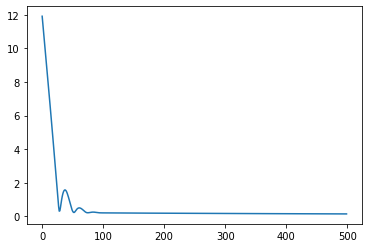

In [94]:
# Create the model:
model_df = Sequential()
model_df.add(Dense(100, activation='relu', input_shape = (n_cols_df,)))
model_df.add(Dense(100, activation='relu'))
model_df.add(Dense(1))

# Create custom metric function: 
def rmse(y_df_test, y_df_pred):
    return backend.sqrt(backend.mean(backend.square(y_df_pred - y_df_test), axis=-1))

# Compile model with optimizer, loss function, and metric function:
model_df.compile(loss='mse', optimizer='adam', metrics=[rmse])

# Fitting the model:
cleaned = model_df.fit(X_df_train, y_df_train, epochs=500, batch_size=len(X_df_train), verbose=2)

# making predictions:
y_df_pred = model_df.predict(X_df_test, batch_size=len(X_df_test))

# Print final performance

# plot metrics
plt.plot(cleaned.history['rmse'])
plt.show()

# Audible cell-completion notification:
Audio('Bicycle-bell.mp3', autoplay=True)

### Pre-processed Data:

In [95]:
# Finding number of input features:
n_cols = X.shape[1]
n_cols

5

Epoch 1/500
1/1 - 0s - loss: 139.5731 - rmse: 11.3598 - 296ms/epoch - 296ms/step
Epoch 2/500
1/1 - 0s - loss: 137.1196 - rmse: 11.2475 - 9ms/epoch - 9ms/step
Epoch 3/500
1/1 - 0s - loss: 134.7377 - rmse: 11.1373 - 9ms/epoch - 9ms/step
Epoch 4/500
1/1 - 0s - loss: 132.4469 - rmse: 11.0300 - 8ms/epoch - 8ms/step
Epoch 5/500
1/1 - 0s - loss: 130.2437 - rmse: 10.9255 - 15ms/epoch - 15ms/step
Epoch 6/500
1/1 - 0s - loss: 128.1430 - rmse: 10.8250 - 9ms/epoch - 9ms/step
Epoch 7/500
1/1 - 0s - loss: 126.0936 - rmse: 10.7257 - 8ms/epoch - 8ms/step
Epoch 8/500
1/1 - 0s - loss: 124.1091 - rmse: 10.6285 - 8ms/epoch - 8ms/step
Epoch 9/500
1/1 - 0s - loss: 122.1784 - rmse: 10.5333 - 16ms/epoch - 16ms/step
Epoch 10/500
1/1 - 0s - loss: 120.2528 - rmse: 10.4374 - 8ms/epoch - 8ms/step
Epoch 11/500
1/1 - 0s - loss: 118.3082 - rmse: 10.3402 - 8ms/epoch - 8ms/step
Epoch 12/500
1/1 - 0s - loss: 116.3365 - rmse: 10.2408 - 8ms/epoch - 8ms/step
Epoch 13/500
1/1 - 0s - loss: 114.3364 - rmse: 10.1388 - 17ms/epo

Epoch 108/500
1/1 - 0s - loss: 13.5914 - rmse: 2.9053 - 14ms/epoch - 14ms/step
Epoch 109/500
1/1 - 0s - loss: 13.4642 - rmse: 2.8890 - 10ms/epoch - 10ms/step
Epoch 110/500
1/1 - 0s - loss: 13.3384 - rmse: 2.8727 - 9ms/epoch - 9ms/step
Epoch 111/500
1/1 - 0s - loss: 13.2141 - rmse: 2.8566 - 9ms/epoch - 9ms/step
Epoch 112/500
1/1 - 0s - loss: 13.0913 - rmse: 2.8407 - 9ms/epoch - 9ms/step
Epoch 113/500
1/1 - 0s - loss: 12.9698 - rmse: 2.8250 - 15ms/epoch - 15ms/step
Epoch 114/500
1/1 - 0s - loss: 12.8496 - rmse: 2.8094 - 9ms/epoch - 9ms/step
Epoch 115/500
1/1 - 0s - loss: 12.7305 - rmse: 2.7938 - 8ms/epoch - 8ms/step
Epoch 116/500
1/1 - 0s - loss: 12.6124 - rmse: 2.7782 - 9ms/epoch - 9ms/step
Epoch 117/500
1/1 - 0s - loss: 12.4953 - rmse: 2.7627 - 16ms/epoch - 16ms/step
Epoch 118/500
1/1 - 0s - loss: 12.3790 - rmse: 2.7473 - 8ms/epoch - 8ms/step
Epoch 119/500
1/1 - 0s - loss: 12.2635 - rmse: 2.7317 - 7ms/epoch - 7ms/step
Epoch 120/500
1/1 - 0s - loss: 12.1489 - rmse: 2.7160 - 11ms/epoch -

Epoch 214/500
1/1 - 0s - loss: 6.8344 - rmse: 1.9106 - 8ms/epoch - 8ms/step
Epoch 215/500
1/1 - 0s - loss: 6.8292 - rmse: 1.9097 - 14ms/epoch - 14ms/step
Epoch 216/500
1/1 - 0s - loss: 6.8242 - rmse: 1.9088 - 11ms/epoch - 11ms/step
Epoch 217/500
1/1 - 0s - loss: 6.8196 - rmse: 1.9080 - 9ms/epoch - 9ms/step
Epoch 218/500
1/1 - 0s - loss: 6.8154 - rmse: 1.9072 - 9ms/epoch - 9ms/step
Epoch 219/500
1/1 - 0s - loss: 6.8114 - rmse: 1.9064 - 9ms/epoch - 9ms/step
Epoch 220/500
1/1 - 0s - loss: 6.8076 - rmse: 1.9056 - 10ms/epoch - 10ms/step
Epoch 221/500
1/1 - 0s - loss: 6.8042 - rmse: 1.9049 - 10ms/epoch - 10ms/step
Epoch 222/500
1/1 - 0s - loss: 6.8009 - rmse: 1.9043 - 13ms/epoch - 13ms/step
Epoch 223/500
1/1 - 0s - loss: 6.7978 - rmse: 1.9037 - 10ms/epoch - 10ms/step
Epoch 224/500
1/1 - 0s - loss: 6.7950 - rmse: 1.9031 - 10ms/epoch - 10ms/step
Epoch 225/500
1/1 - 0s - loss: 6.7923 - rmse: 1.9026 - 9ms/epoch - 9ms/step
Epoch 226/500
1/1 - 0s - loss: 6.7898 - rmse: 1.9021 - 11ms/epoch - 11ms/s

Epoch 321/500
1/1 - 0s - loss: 6.6878 - rmse: 1.8808 - 10ms/epoch - 10ms/step
Epoch 322/500
1/1 - 0s - loss: 6.6870 - rmse: 1.8806 - 9ms/epoch - 9ms/step
Epoch 323/500
1/1 - 0s - loss: 6.6862 - rmse: 1.8804 - 8ms/epoch - 8ms/step
Epoch 324/500
1/1 - 0s - loss: 6.6854 - rmse: 1.8803 - 9ms/epoch - 9ms/step
Epoch 325/500
1/1 - 0s - loss: 6.6846 - rmse: 1.8801 - 9ms/epoch - 9ms/step
Epoch 326/500
1/1 - 0s - loss: 6.6838 - rmse: 1.8800 - 10ms/epoch - 10ms/step
Epoch 327/500
1/1 - 0s - loss: 6.6830 - rmse: 1.8798 - 10ms/epoch - 10ms/step
Epoch 328/500
1/1 - 0s - loss: 6.6823 - rmse: 1.8796 - 10ms/epoch - 10ms/step
Epoch 329/500
1/1 - 0s - loss: 6.6815 - rmse: 1.8795 - 9ms/epoch - 9ms/step
Epoch 330/500
1/1 - 0s - loss: 6.6807 - rmse: 1.8793 - 9ms/epoch - 9ms/step
Epoch 331/500
1/1 - 0s - loss: 6.6799 - rmse: 1.8792 - 9ms/epoch - 9ms/step
Epoch 332/500
1/1 - 0s - loss: 6.6791 - rmse: 1.8790 - 9ms/epoch - 9ms/step
Epoch 333/500
1/1 - 0s - loss: 6.6784 - rmse: 1.8789 - 11ms/epoch - 11ms/step
Ep

Epoch 428/500
1/1 - 0s - loss: 6.6126 - rmse: 1.8659 - 10ms/epoch - 10ms/step
Epoch 429/500
1/1 - 0s - loss: 6.6120 - rmse: 1.8658 - 9ms/epoch - 9ms/step
Epoch 430/500
1/1 - 0s - loss: 6.6114 - rmse: 1.8657 - 9ms/epoch - 9ms/step
Epoch 431/500
1/1 - 0s - loss: 6.6108 - rmse: 1.8656 - 8ms/epoch - 8ms/step
Epoch 432/500
1/1 - 0s - loss: 6.6102 - rmse: 1.8654 - 10ms/epoch - 10ms/step
Epoch 433/500
1/1 - 0s - loss: 6.6095 - rmse: 1.8653 - 10ms/epoch - 10ms/step
Epoch 434/500
1/1 - 0s - loss: 6.6089 - rmse: 1.8652 - 9ms/epoch - 9ms/step
Epoch 435/500
1/1 - 0s - loss: 6.6083 - rmse: 1.8651 - 14ms/epoch - 14ms/step
Epoch 436/500
1/1 - 0s - loss: 6.6077 - rmse: 1.8650 - 10ms/epoch - 10ms/step
Epoch 437/500
1/1 - 0s - loss: 6.6071 - rmse: 1.8648 - 8ms/epoch - 8ms/step
Epoch 438/500
1/1 - 0s - loss: 6.6065 - rmse: 1.8647 - 10ms/epoch - 10ms/step
Epoch 439/500
1/1 - 0s - loss: 6.6059 - rmse: 1.8646 - 9ms/epoch - 9ms/step
Epoch 440/500
1/1 - 0s - loss: 6.6052 - rmse: 1.8644 - 8ms/epoch - 8ms/step


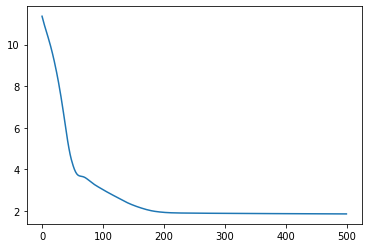

In [96]:
# Create the model:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (n_cols,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# Compile model with optimizer, loss function, and metric function:
model.compile(loss='mse', optimizer='adam', metrics=[rmse])

# Fitting the model:
preprocessed = model.fit(X_train, y_train, epochs=500, batch_size=len(X_train), verbose=2)

# making predictions:
y_pred = model.predict(X_test, batch_size=len(X_test))
    
# plot metrics
plt.plot(preprocessed.history['rmse'])
plt.show()

# Audible cell-completion notification:
Audio('Bicycle-bell.mp3', autoplay=True)

### It is worth noting that model used on the dataset that was simply cleaned significantly outperformed the model on the dataset that had been pre-processed:
**Final Values for simply Cleaned:**
loss: 0.0374 - rmse: 0.1399\
**Final Values for Pre-processed:**
loss: 6.5692 - rmse: 1.8577

## 4. Write another algorithm to predict the same result as the previous question using either KNN or logistic regression.

### Creating KNR:

### Cleaned data:

In [98]:
# Finding number of input features:
n_cols_df_knr = X_df.shape[1]
n_cols_df_knr

9

Epoch 1/500
1/1 - 0s - loss: 151.8444 - rmse: 11.8662 - 310ms/epoch - 310ms/step
Epoch 2/500
1/1 - 0s - loss: 140.7099 - rmse: 11.4252 - 8ms/epoch - 8ms/step
Epoch 3/500
1/1 - 0s - loss: 130.4668 - rmse: 11.0043 - 8ms/epoch - 8ms/step
Epoch 4/500
1/1 - 0s - loss: 121.0173 - rmse: 10.6017 - 9ms/epoch - 9ms/step
Epoch 5/500
1/1 - 0s - loss: 112.1098 - rmse: 10.2070 - 16ms/epoch - 16ms/step
Epoch 6/500
1/1 - 0s - loss: 103.7885 - rmse: 9.8232 - 10ms/epoch - 10ms/step
Epoch 7/500
1/1 - 0s - loss: 96.1866 - rmse: 9.4575 - 9ms/epoch - 9ms/step
Epoch 8/500
1/1 - 0s - loss: 89.0916 - rmse: 9.1015 - 8ms/epoch - 8ms/step
Epoch 9/500
1/1 - 0s - loss: 82.2321 - rmse: 8.7441 - 17ms/epoch - 17ms/step
Epoch 10/500
1/1 - 0s - loss: 75.5293 - rmse: 8.3808 - 10ms/epoch - 10ms/step
Epoch 11/500
1/1 - 0s - loss: 68.9775 - rmse: 8.0100 - 8ms/epoch - 8ms/step
Epoch 12/500
1/1 - 0s - loss: 62.6261 - rmse: 7.6337 - 8ms/epoch - 8ms/step
Epoch 13/500
1/1 - 0s - loss: 56.5293 - rmse: 7.2535 - 19ms/epoch - 19ms/s

Epoch 109/500
1/1 - 0s - loss: 0.0584 - rmse: 0.1811 - 11ms/epoch - 11ms/step
Epoch 110/500
1/1 - 0s - loss: 0.0580 - rmse: 0.1803 - 12ms/epoch - 12ms/step
Epoch 111/500
1/1 - 0s - loss: 0.0577 - rmse: 0.1799 - 18ms/epoch - 18ms/step
Epoch 112/500
1/1 - 0s - loss: 0.0575 - rmse: 0.1797 - 8ms/epoch - 8ms/step
Epoch 113/500
1/1 - 0s - loss: 0.0574 - rmse: 0.1797 - 8ms/epoch - 8ms/step
Epoch 114/500
1/1 - 0s - loss: 0.0573 - rmse: 0.1797 - 9ms/epoch - 9ms/step
Epoch 115/500
1/1 - 0s - loss: 0.0573 - rmse: 0.1796 - 10ms/epoch - 10ms/step
Epoch 116/500
1/1 - 0s - loss: 0.0572 - rmse: 0.1795 - 8ms/epoch - 8ms/step
Epoch 117/500
1/1 - 0s - loss: 0.0571 - rmse: 0.1794 - 7ms/epoch - 7ms/step
Epoch 118/500
1/1 - 0s - loss: 0.0570 - rmse: 0.1790 - 9ms/epoch - 9ms/step
Epoch 119/500
1/1 - 0s - loss: 0.0569 - rmse: 0.1786 - 9ms/epoch - 9ms/step
Epoch 120/500
1/1 - 0s - loss: 0.0567 - rmse: 0.1781 - 15ms/epoch - 15ms/step
Epoch 121/500
1/1 - 0s - loss: 0.0564 - rmse: 0.1775 - 9ms/epoch - 9ms/step
Ep

Epoch 216/500
1/1 - 0s - loss: 0.0494 - rmse: 0.1644 - 13ms/epoch - 13ms/step
Epoch 217/500
1/1 - 0s - loss: 0.0493 - rmse: 0.1642 - 9ms/epoch - 9ms/step
Epoch 218/500
1/1 - 0s - loss: 0.0492 - rmse: 0.1640 - 9ms/epoch - 9ms/step
Epoch 219/500
1/1 - 0s - loss: 0.0491 - rmse: 0.1639 - 16ms/epoch - 16ms/step
Epoch 220/500
1/1 - 0s - loss: 0.0490 - rmse: 0.1637 - 10ms/epoch - 10ms/step
Epoch 221/500
1/1 - 0s - loss: 0.0489 - rmse: 0.1635 - 8ms/epoch - 8ms/step
Epoch 222/500
1/1 - 0s - loss: 0.0488 - rmse: 0.1633 - 46ms/epoch - 46ms/step
Epoch 223/500
1/1 - 0s - loss: 0.0487 - rmse: 0.1630 - 9ms/epoch - 9ms/step
Epoch 224/500
1/1 - 0s - loss: 0.0486 - rmse: 0.1628 - 10ms/epoch - 10ms/step
Epoch 225/500
1/1 - 0s - loss: 0.0485 - rmse: 0.1626 - 9ms/epoch - 9ms/step
Epoch 226/500
1/1 - 0s - loss: 0.0484 - rmse: 0.1624 - 10ms/epoch - 10ms/step
Epoch 227/500
1/1 - 0s - loss: 0.0483 - rmse: 0.1622 - 13ms/epoch - 13ms/step
Epoch 228/500
1/1 - 0s - loss: 0.0482 - rmse: 0.1620 - 26ms/epoch - 26ms/s

Epoch 323/500
1/1 - 0s - loss: 0.0175 - rmse: 0.0972 - 9ms/epoch - 9ms/step
Epoch 324/500
1/1 - 0s - loss: 0.0171 - rmse: 0.0961 - 9ms/epoch - 9ms/step
Epoch 325/500
1/1 - 0s - loss: 0.0168 - rmse: 0.0951 - 10ms/epoch - 10ms/step
Epoch 326/500
1/1 - 0s - loss: 0.0164 - rmse: 0.0940 - 10ms/epoch - 10ms/step
Epoch 327/500
1/1 - 0s - loss: 0.0161 - rmse: 0.0930 - 8ms/epoch - 8ms/step
Epoch 328/500
1/1 - 0s - loss: 0.0158 - rmse: 0.0919 - 13ms/epoch - 13ms/step
Epoch 329/500
1/1 - 0s - loss: 0.0154 - rmse: 0.0909 - 10ms/epoch - 10ms/step
Epoch 330/500
1/1 - 0s - loss: 0.0151 - rmse: 0.0898 - 14ms/epoch - 14ms/step
Epoch 331/500
1/1 - 0s - loss: 0.0148 - rmse: 0.0888 - 13ms/epoch - 13ms/step
Epoch 332/500
1/1 - 0s - loss: 0.0145 - rmse: 0.0878 - 13ms/epoch - 13ms/step
Epoch 333/500
1/1 - 0s - loss: 0.0141 - rmse: 0.0867 - 10ms/epoch - 10ms/step
Epoch 334/500
1/1 - 0s - loss: 0.0138 - rmse: 0.0857 - 11ms/epoch - 11ms/step
Epoch 335/500
1/1 - 0s - loss: 0.0135 - rmse: 0.0847 - 9ms/epoch - 9ms

Epoch 430/500
1/1 - 0s - loss: 0.0030 - rmse: 0.0351 - 9ms/epoch - 9ms/step
Epoch 431/500
1/1 - 0s - loss: 0.0030 - rmse: 0.0349 - 9ms/epoch - 9ms/step
Epoch 432/500
1/1 - 0s - loss: 0.0030 - rmse: 0.0348 - 11ms/epoch - 11ms/step
Epoch 433/500
1/1 - 0s - loss: 0.0030 - rmse: 0.0347 - 11ms/epoch - 11ms/step
Epoch 434/500
1/1 - 0s - loss: 0.0030 - rmse: 0.0346 - 9ms/epoch - 9ms/step
Epoch 435/500
1/1 - 0s - loss: 0.0029 - rmse: 0.0344 - 12ms/epoch - 12ms/step
Epoch 436/500
1/1 - 0s - loss: 0.0029 - rmse: 0.0343 - 16ms/epoch - 16ms/step
Epoch 437/500
1/1 - 0s - loss: 0.0029 - rmse: 0.0342 - 10ms/epoch - 10ms/step
Epoch 438/500
1/1 - 0s - loss: 0.0029 - rmse: 0.0341 - 15ms/epoch - 15ms/step
Epoch 439/500
1/1 - 0s - loss: 0.0029 - rmse: 0.0340 - 11ms/epoch - 11ms/step
Epoch 440/500
1/1 - 0s - loss: 0.0029 - rmse: 0.0339 - 10ms/epoch - 10ms/step
Epoch 441/500
1/1 - 0s - loss: 0.0028 - rmse: 0.0338 - 12ms/epoch - 12ms/step
Epoch 442/500
1/1 - 0s - loss: 0.0028 - rmse: 0.0337 - 14ms/epoch - 14

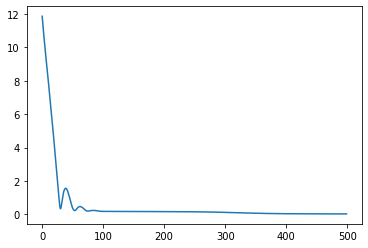

In [99]:
# Create the model:
model_df_knr = Sequential()
model_df_knr.add(Dense(100, activation='relu', input_shape = (n_cols_df_knr,)))
model_df_knr.add(Dense(100, activation='relu'))
model_df_knr.add(Dense(1))

# Compile model with optimizer, loss function, and metric function:
model_df_knr.compile(loss='mse', optimizer='adam', metrics=[rmse])

# Fitting the model:
cleaned_knr = model_df_knr.fit(X_df_train, y_df_train, epochs=500, batch_size=len(X_df_train), verbose=2)

# making predictions:
y_df_pred_knr = model_df_knr.predict(X_df_test, batch_size=len(X_df_test))

# Print final performance

# plot metrics
plt.plot(cleaned_knr.history['rmse'])
plt.show()

### Pre-processed Data:

In [100]:
# Finding number of input features:
n_cols = X.shape[1]
n_cols

5

Epoch 1/500
1/1 - 0s - loss: 142.6404 - rmse: 11.4889 - 309ms/epoch - 309ms/step
Epoch 2/500
1/1 - 0s - loss: 140.5382 - rmse: 11.3950 - 9ms/epoch - 9ms/step
Epoch 3/500
1/1 - 0s - loss: 138.4766 - rmse: 11.3022 - 9ms/epoch - 9ms/step
Epoch 4/500
1/1 - 0s - loss: 136.4453 - rmse: 11.2101 - 13ms/epoch - 13ms/step
Epoch 5/500
1/1 - 0s - loss: 134.4278 - rmse: 11.1179 - 14ms/epoch - 14ms/step
Epoch 6/500
1/1 - 0s - loss: 132.4000 - rmse: 11.0245 - 10ms/epoch - 10ms/step
Epoch 7/500
1/1 - 0s - loss: 130.3581 - rmse: 10.9297 - 12ms/epoch - 12ms/step
Epoch 8/500
1/1 - 0s - loss: 128.2837 - rmse: 10.8322 - 15ms/epoch - 15ms/step
Epoch 9/500
1/1 - 0s - loss: 126.1727 - rmse: 10.7320 - 8ms/epoch - 8ms/step
Epoch 10/500
1/1 - 0s - loss: 124.0433 - rmse: 10.6299 - 12ms/epoch - 12ms/step
Epoch 11/500
1/1 - 0s - loss: 121.9181 - rmse: 10.5270 - 13ms/epoch - 13ms/step
Epoch 12/500
1/1 - 0s - loss: 119.7892 - rmse: 10.4230 - 8ms/epoch - 8ms/step
Epoch 13/500
1/1 - 0s - loss: 117.6416 - rmse: 10.3172 

Epoch 107/500
1/1 - 0s - loss: 11.1695 - rmse: 2.5618 - 10ms/epoch - 10ms/step
Epoch 108/500
1/1 - 0s - loss: 11.0625 - rmse: 2.5485 - 8ms/epoch - 8ms/step
Epoch 109/500
1/1 - 0s - loss: 10.9573 - rmse: 2.5353 - 11ms/epoch - 11ms/step
Epoch 110/500
1/1 - 0s - loss: 10.8537 - rmse: 2.5221 - 11ms/epoch - 11ms/step
Epoch 111/500
1/1 - 0s - loss: 10.7516 - rmse: 2.5089 - 10ms/epoch - 10ms/step
Epoch 112/500
1/1 - 0s - loss: 10.6508 - rmse: 2.4955 - 9ms/epoch - 9ms/step
Epoch 113/500
1/1 - 0s - loss: 10.5512 - rmse: 2.4821 - 8ms/epoch - 8ms/step
Epoch 114/500
1/1 - 0s - loss: 10.4528 - rmse: 2.4686 - 16ms/epoch - 16ms/step
Epoch 115/500
1/1 - 0s - loss: 10.3554 - rmse: 2.4550 - 9ms/epoch - 9ms/step
Epoch 116/500
1/1 - 0s - loss: 10.2593 - rmse: 2.4412 - 9ms/epoch - 9ms/step
Epoch 117/500
1/1 - 0s - loss: 10.1643 - rmse: 2.4274 - 8ms/epoch - 8ms/step
Epoch 118/500
1/1 - 0s - loss: 10.0707 - rmse: 2.4136 - 17ms/epoch - 17ms/step
Epoch 119/500
1/1 - 0s - loss: 9.9785 - rmse: 2.3997 - 9ms/epoch

Epoch 213/500
1/1 - 0s - loss: 6.8438 - rmse: 1.9049 - 12ms/epoch - 12ms/step
Epoch 214/500
1/1 - 0s - loss: 6.8417 - rmse: 1.9043 - 9ms/epoch - 9ms/step
Epoch 215/500
1/1 - 0s - loss: 6.8397 - rmse: 1.9039 - 15ms/epoch - 15ms/step
Epoch 216/500
1/1 - 0s - loss: 6.8378 - rmse: 1.9037 - 12ms/epoch - 12ms/step
Epoch 217/500
1/1 - 0s - loss: 6.8360 - rmse: 1.9036 - 12ms/epoch - 12ms/step
Epoch 218/500
1/1 - 0s - loss: 6.8343 - rmse: 1.9036 - 7ms/epoch - 7ms/step
Epoch 219/500
1/1 - 0s - loss: 6.8327 - rmse: 1.9037 - 9ms/epoch - 9ms/step
Epoch 220/500
1/1 - 0s - loss: 6.8311 - rmse: 1.9038 - 12ms/epoch - 12ms/step
Epoch 221/500
1/1 - 0s - loss: 6.8296 - rmse: 1.9040 - 9ms/epoch - 9ms/step
Epoch 222/500
1/1 - 0s - loss: 6.8282 - rmse: 1.9041 - 10ms/epoch - 10ms/step
Epoch 223/500
1/1 - 0s - loss: 6.8269 - rmse: 1.9043 - 10ms/epoch - 10ms/step
Epoch 224/500
1/1 - 0s - loss: 6.8256 - rmse: 1.9045 - 12ms/epoch - 12ms/step
Epoch 225/500
1/1 - 0s - loss: 6.8244 - rmse: 1.9045 - 10ms/epoch - 10ms

Epoch 319/500
1/1 - 0s - loss: 6.7390 - rmse: 1.8860 - 14ms/epoch - 14ms/step
Epoch 320/500
1/1 - 0s - loss: 6.7382 - rmse: 1.8858 - 10ms/epoch - 10ms/step
Epoch 321/500
1/1 - 0s - loss: 6.7374 - rmse: 1.8856 - 10ms/epoch - 10ms/step
Epoch 322/500
1/1 - 0s - loss: 6.7365 - rmse: 1.8855 - 11ms/epoch - 11ms/step
Epoch 323/500
1/1 - 0s - loss: 6.7357 - rmse: 1.8853 - 9ms/epoch - 9ms/step
Epoch 324/500
1/1 - 0s - loss: 6.7349 - rmse: 1.8852 - 8ms/epoch - 8ms/step
Epoch 325/500
1/1 - 0s - loss: 6.7341 - rmse: 1.8850 - 10ms/epoch - 10ms/step
Epoch 326/500
1/1 - 0s - loss: 6.7333 - rmse: 1.8849 - 9ms/epoch - 9ms/step
Epoch 327/500
1/1 - 0s - loss: 6.7325 - rmse: 1.8847 - 11ms/epoch - 11ms/step
Epoch 328/500
1/1 - 0s - loss: 6.7317 - rmse: 1.8846 - 10ms/epoch - 10ms/step
Epoch 329/500
1/1 - 0s - loss: 6.7309 - rmse: 1.8844 - 10ms/epoch - 10ms/step
Epoch 330/500
1/1 - 0s - loss: 6.7301 - rmse: 1.8843 - 8ms/epoch - 8ms/step
Epoch 331/500
1/1 - 0s - loss: 6.7293 - rmse: 1.8842 - 8ms/epoch - 8ms/s

Epoch 425/500
1/1 - 0s - loss: 6.6571 - rmse: 1.8706 - 9ms/epoch - 9ms/step
Epoch 426/500
1/1 - 0s - loss: 6.6564 - rmse: 1.8705 - 13ms/epoch - 13ms/step
Epoch 427/500
1/1 - 0s - loss: 6.6556 - rmse: 1.8703 - 13ms/epoch - 13ms/step
Epoch 428/500
1/1 - 0s - loss: 6.6549 - rmse: 1.8702 - 14ms/epoch - 14ms/step
Epoch 429/500
1/1 - 0s - loss: 6.6541 - rmse: 1.8700 - 11ms/epoch - 11ms/step
Epoch 430/500
1/1 - 0s - loss: 6.6534 - rmse: 1.8699 - 10ms/epoch - 10ms/step
Epoch 431/500
1/1 - 0s - loss: 6.6526 - rmse: 1.8698 - 79ms/epoch - 79ms/step
Epoch 432/500
1/1 - 0s - loss: 6.6518 - rmse: 1.8696 - 11ms/epoch - 11ms/step
Epoch 433/500
1/1 - 0s - loss: 6.6511 - rmse: 1.8695 - 9ms/epoch - 9ms/step
Epoch 434/500
1/1 - 0s - loss: 6.6503 - rmse: 1.8694 - 8ms/epoch - 8ms/step
Epoch 435/500
1/1 - 0s - loss: 6.6496 - rmse: 1.8692 - 9ms/epoch - 9ms/step
Epoch 436/500
1/1 - 0s - loss: 6.6488 - rmse: 1.8691 - 10ms/epoch - 10ms/step
Epoch 437/500
1/1 - 0s - loss: 6.6481 - rmse: 1.8690 - 10ms/epoch - 10ms

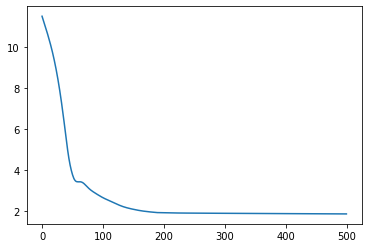

In [101]:
# Create the model:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (n_cols,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# Compile model with optimizer, loss function, and metric function:
model.compile(loss='mse', optimizer='adam', metrics=[rmse])

# Fitting the model:
preprocessed = model.fit(X_train, y_train, epochs=500, batch_size=len(X_train), verbose=2)

# making predictions:
y_pred = model.predict(X_test, batch_size=len(X_test))
    
# plot metrics
plt.plot(preprocessed.history['rmse'])
plt.show()

## 5. Create a neural network using pytorch to predict the same result as question 3. 

## 6. Compare the performance of the neural networks to the other model you created. Which performed better? Why do you think that is?

# DataCamp Completion:

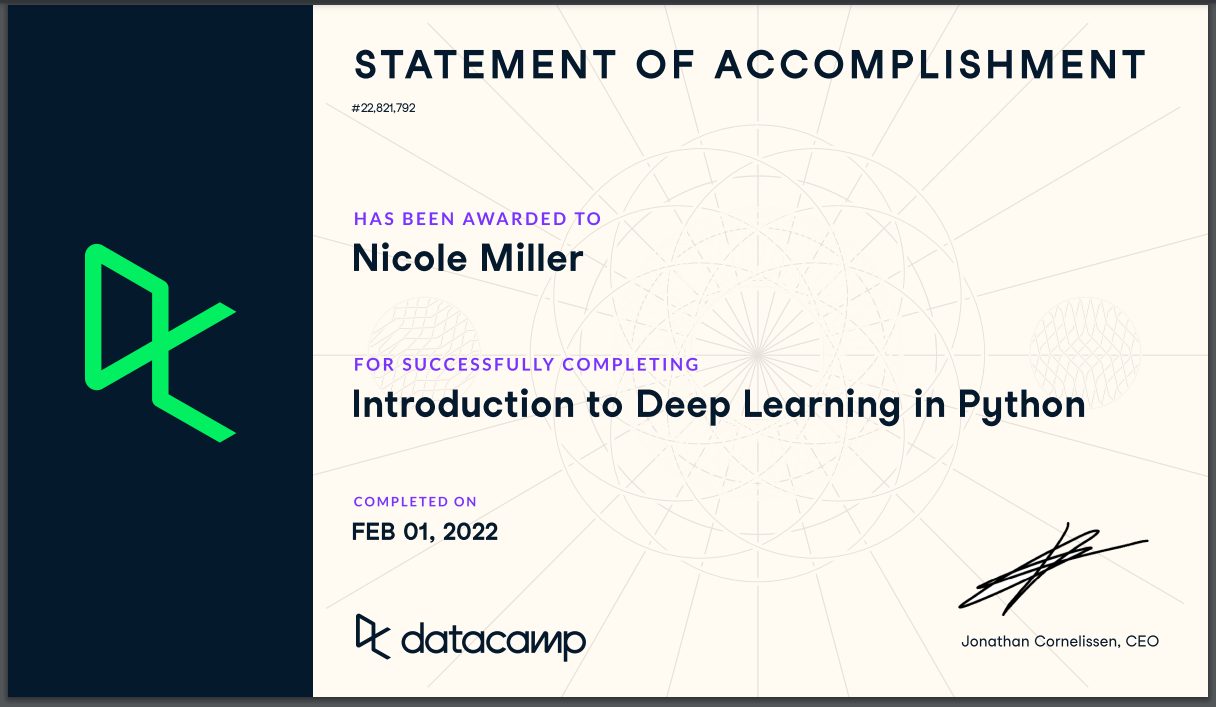